# Sentiment Analysis for Drug Reviews

#### Importing Libraries

In [273]:
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
# %matplotlib inline
plt.style.use('seaborn-whitegrid')
sns.set_context("poster")
from sklearn import externals
import joblib
from pandas import MultiIndex, Int64Index

import gensim
from gensim.utils import simple_preprocess
import spacy
import wordcloud

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses


from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer



import keras
import imblearn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.models import Sequential
from tensorflow.keras import layers
from imblearn.base import BaseSampler
from keras.layers import Dense, Dropout






from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D


import warnings
warnings.filterwarnings("ignore")


print("Setup Complete")

Setup Complete


#### Importing the Dataset 

In [2]:
dataset_1 = pd.read_csv('drugsComTrain_raw.tsv', sep = '\t')
dataset_2 = pd.read_csv('drugsComTest_raw.tsv', sep = '\t')
dataset_1.head()
dataset_2.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4


In [3]:
dataset_1 = dataset_1[:10000]
dataset_2 = dataset_2[:10000]

#### Combining the datasets and Extracting the Important Attributes

In [4]:
df = pd.concat([dataset_1,dataset_2])[['drugName','condition','review', 'rating']]
df

,drugName,condition,review,rating
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0
...,...,...,...,...
9995,Ativan,Insomnia,"""I was given Ativan for occasional use. I try ...",9.0
9996,Erythromycin,Upper Respiratory Tract Infection,"""This antibiotic is the best, hands down. The...",10.0
9997,Plan B,Emergency Contraception,"""I took this pill on June 16th 2015. I was rea...",10.0
9998,Dilaudid,Pain,"""I developed severe pancreatitis and hepatitis...",10.0


In [5]:
df.describe()

,rating
count,20000.000000
mean,6.973900
std,3.282173
min,1.000000
25%,4.000000
50%,8.000000
75%,10.000000
max,10.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   drugName   20000 non-null  object 
 1   condition  19893 non-null  object 
 2   review     20000 non-null  object 
 3   rating     20000 non-null  float64
dtypes: float64(1), object(3)
memory usage: 781.2+ KB


In [7]:
df = df.dropna() #dropping all rows with nan values

In [8]:
df.count()

drugName     19893
condition    19893
review       19893
rating       19893
dtype: int64

In [9]:
pd.DataFrame.to_csv(df, 'textsentiment.csv', sep=',', index=False)

In [10]:
df = pd.read_csv('textsentiment.csv')
df.head(2)

,drugName,condition,review,rating
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0


In [11]:
df['review'] = [str (item) for item in df['review']]

#### Cleaning the Text
First stage Text cleaning 

In [12]:
enableStopwords = True
if enableStopwords:
    df['review'] = df['review'].str.replace("&#039;", "'", regex=False)
    df.head(2)

In [13]:
enableStopwords = True
if enableStopwords:
    df['review'] = df['review'].str.replace('[!@#$%^"&*]', "", regex=False)
    df.head(2)

In [15]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
for i in range(0, 19893):
    Review = re.sub('[^a-zA-Z]', ' ', df['review'][i])
    Review = Review.lower()
    Review = Review.split()
    ps = PorterStemmer()
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    Review = [ps.stem(word) for word in Review if not word in set(all_stopwords)]
    Review = ' '.join(Review)
    corpus.append(Review)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
corpus[30]

'week zoloft anxieti mood swing take mg morn breakfast nausea day one subsid week went get jitter hr take follow yawn feel much better though less angri stress'

# Exploratory Data Analysis

In [38]:
df = df.drop(['review'], axis = 1)

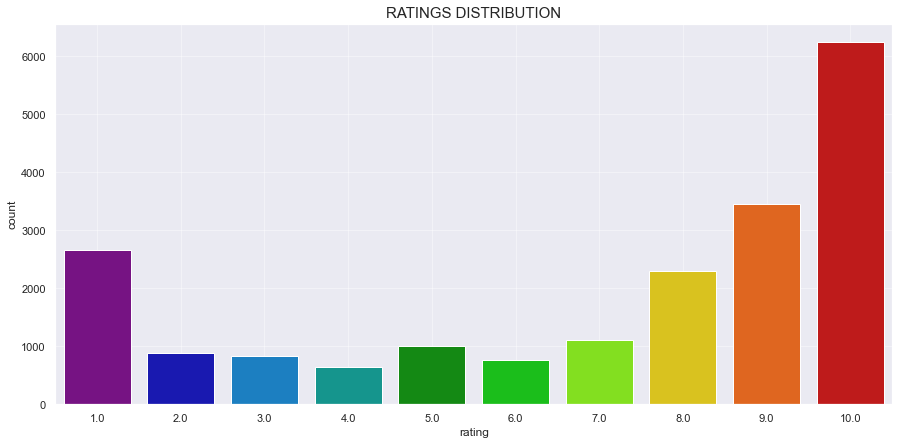

In [36]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(df["rating"], palette="nipy_spectral")
plt.title("RATINGS DISTRIBUTION", fontsize=15)
plt.grid(alpha=0.4)

Distribution of Conditions (Top 20)

In [ ]:
con = df["condition"].value_counts()

<AxesSubplot:>

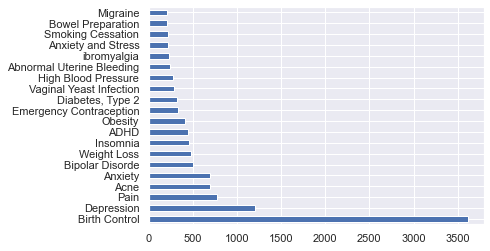

In [31]:
con[:20].plot(kind="barh")

Distribution of Drug Name

In [33]:
drug = df["drugName"].value_counts()

<AxesSubplot:>

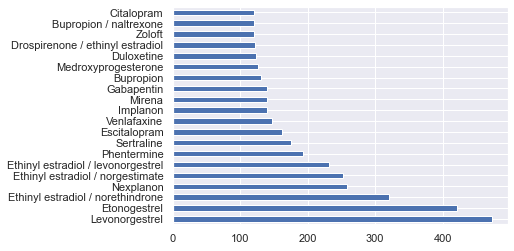

In [34]:
drug[:20].plot(kind="barh")

### Sentiment Intensity Analysis

In [39]:
df

,drugName,condition,rating
0,Valsartan,Left Ventricular Dysfunction,9.0
1,Guanfacine,ADHD,8.0
2,Lybrel,Birth Control,5.0
3,Ortho Evra,Birth Control,8.0
4,Buprenorphine / naloxone,Opiate Dependence,9.0
...,...,...,...
19888,Ativan,Insomnia,9.0
19889,Erythromycin,Upper Respiratory Tract Infection,10.0
19890,Plan B,Emergency Contraception,10.0
19891,Dilaudid,Pain,10.0


In [40]:
df['Reviews'] = corpus
df

,drugName,condition,rating,Reviews
0,Valsartan,Left Ventricular Dysfunction,9.0,side effect take combin bystol mg fish oil
1,Guanfacine,ADHD,8.0,son halfway fourth week intuniv becam concern ...
2,Lybrel,Birth Control,5.0,use take anoth oral contracept pill cycl happi...
3,Ortho Evra,Birth Control,8.0,first time use form birth control glad went pa...
4,Buprenorphine / naloxone,Opiate Dependence,9.0,suboxon complet turn life around feel healthie...
...,...,...,...,...
19888,Ativan,Insomnia,9.0,given ativan occasion use tri use everi week e...
19889,Erythromycin,Upper Respiratory Tract Infection,10.0,antibiot best hand z pack even come close take...
19890,Plan B,Emergency Contraception,10.0,took pill june th realli scare amp nervou came...
19891,Dilaudid,Pain,10.0,develop sever pancreat hepat due gallston tri ...


In [41]:
#saving file to track changes

pd.DataFrame.to_csv(df, 'corpus.csv', sep=',', index=False)

df = pd.read_csv('corpus.csv')
df.head(2)

,drugName,condition,rating,Reviews
0,Valsartan,Left Ventricular Dysfunction,9.0,side effect take combin bystol mg fish oil
1,Guanfacine,ADHD,8.0,son halfway fourth week intuniv becam concern ...


Polarity is how positive or negative users sentiments are. The score classifies their reviews.

In [42]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()


df["Review"] = df["Reviews"].apply(lambda x: sid.polarity_scores(x))

df = pd.concat([df.drop(['Review'], axis=1), df['Review'].apply(pd.Series)], axis=1)

df[['drugName','rating','Reviews','neg','neu','pos','compound']].head(7)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,drugName,rating,Reviews,neg,neu,pos,compound
0,Valsartan,9.0,side effect take combin bystol mg fish oil,0.000,1.000,0.000,0.0000
1,Guanfacine,8.0,son halfway fourth week intuniv becam concern ...,0.037,0.841,0.122,0.7287
2,Lybrel,5.0,use take anoth oral contracept pill cycl happi...,0.000,0.954,0.046,0.5106
3,Ortho Evra,8.0,first time use form birth control glad went pa...,0.085,0.845,0.070,0.1027
4,Buprenorphine / naloxone,9.0,suboxon complet turn life around feel healthie...,0.073,0.707,0.219,0.8934
5,Cialis,2.0,nd day mg start work rock hard erect howev exp...,0.189,0.712,0.099,-0.4881
6,Levonorgestrel,1.0,pull cum bit took plan b hour later took pregn...,0.000,1.000,0.000,0.0000


# Inspecting the sentiments distribution
* Comparing ratings and sentiments derived from sentiment Analyzer Module
* Converting reviews to binary 1, 2, and 3 to mapping 0-3 as negative ratings, 4-6 as neutral and 7-10 as positive review

In [43]:
df['Liked'] = df['rating']

In [44]:
df.loc[(df['Liked'] <= 3),'rating']='negative'

In [45]:
df.loc[(df['Liked'] >= 4) & (df['Liked'] < 7),'rating']='neutral'

In [46]:
df.loc[(df['Liked'] >= 7),'rating']='positive'

In [47]:
df['rating'].unique()

array(['positive', 'neutral', 'negative'], dtype=object)

In [49]:
df.head()

,drugName,condition,rating,Reviews,neg,neu,pos,compound,Liked
0,Valsartan,Left Ventricular Dysfunction,positive,side effect take combin bystol mg fish oil,0.000,1.000,0.000,0.0000,9.0
1,Guanfacine,ADHD,positive,son halfway fourth week intuniv becam concern ...,0.037,0.841,0.122,0.7287,8.0
2,Lybrel,Birth Control,neutral,use take anoth oral contracept pill cycl happi...,0.000,0.954,0.046,0.5106,5.0
3,Ortho Evra,Birth Control,positive,first time use form birth control glad went pa...,0.085,0.845,0.070,0.1027,8.0
4,Buprenorphine / naloxone,Opiate Dependence,positive,suboxon complet turn life around feel healthie...,0.073,0.707,0.219,0.8934,9.0


In [50]:
new_df = df.values.tolist()

In [51]:
new_df

[['Valsartan',
  'Left Ventricular Dysfunction',
  'positive',
  'side effect take combin bystol mg fish oil',
  0.0,
  1.0,
  0.0,
  0.0,
  9.0],
 ['Guanfacine',
  'ADHD',
  'positive',
  'son halfway fourth week intuniv becam concern began last week start take highest dose two day could hardli get bed cranki slept nearli hour drive home school vacat unusu call doctor monday morn said stick day see school get morn last two day problem free much agreeabl ever less emot good thing less cranki rememb thing overal behavior better tri mani differ medic far effect',
  0.037,
  0.841,
  0.122,
  0.7287,
  8.0],
 ['Lybrel',
  'Birth Control',
  'neutral',
  'use take anoth oral contracept pill cycl happi light period max day side effect contain hormon gestoden not avail us switch lybrel ingredi similar pill end start lybrel immedi first day period instruct said period last two week take second pack two week third pack thing got even wors third period last two week end third week still daili b

In [55]:
sentiment.clear()

In [56]:
# # Meaning of labels
# #==================
# #3-Negative(LINE 4)
# #2-Neutral(LINE 5)
# #1-Positive(lINE 6)

sentiment = []

for linenum, line in enumerate(new_df):
    if line[4]==line[5] and line[4] == line[6]:
        sentiment.append('negative')
    elif line[4]>line[5] and line[4] > line[6]:
        sentiment.append('negative')
    elif line[5]>line[6] and line[5]>line[4]:
        sentiment.append('neutral')
    elif line[6]>line[4] and line[6]>line[5]:
        sentiment.append('positive')
    else:
        sentiment.append('positive')

In [57]:
df['sentiment'] = sentiment

In [58]:
df.loc[(df["sentiment"] == "negative"), "sentiment"] = 3

df.loc[(df["sentiment"] == "neutral"), "sentiment"] = 2

df.loc[(df["sentiment"] == "positive"), "sentiment"] = 1

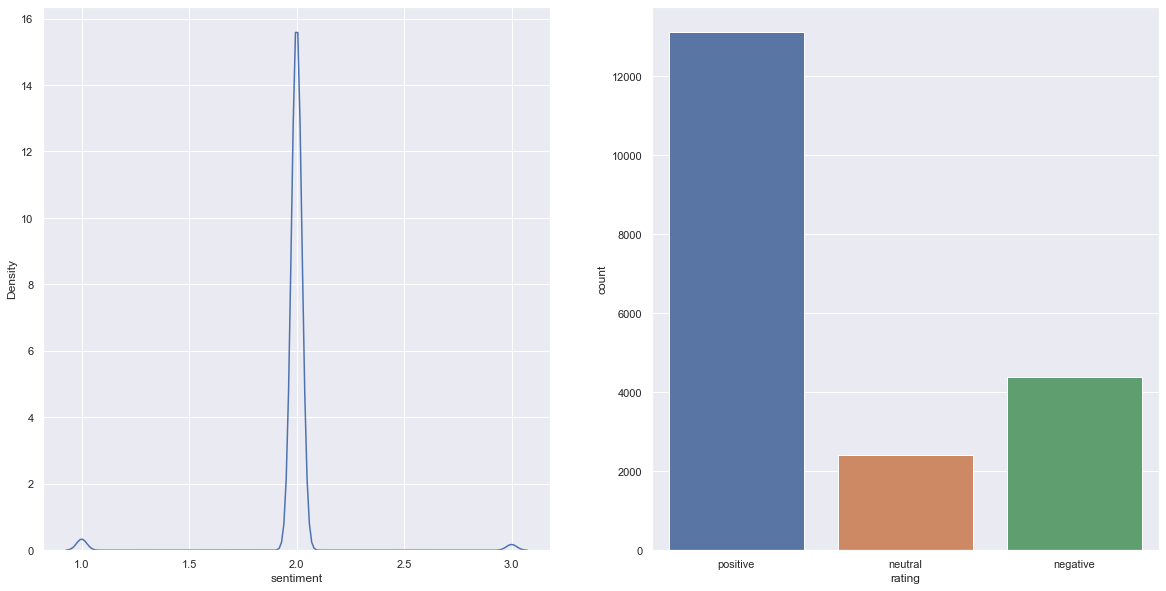

In [63]:
# Comparing report generated by sentiment analyzer and ratings
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.kdeplot(data=df, x="sentiment") 

plt.subplot(1, 2, 2)
ax = sns.countplot(data=df, x='rating')
plt.show()

* The above plots revealed that the sentiment analyzer's result(L) is extremely <br> skewed towards neutral sentiments which dooes not correlate with the ratings(L).
* Customers ratings from the data showed a more positive review from the over all.

* The rating looks more a fair distribution

In [65]:
data = df.drop(['drugName', 'condition', 'neg','neu', 'pos', 'Liked', 'compound', 'sentiment'], axis=1)

In [66]:
#rearranging the dataframe

data = data[['Reviews', 'rating']]

### WordCloud
* Adapting Applied Artificial Intelligence class

In [67]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=False))
        

new_corpus = sent_to_words(corpus)
print('new_corpus', new_corpus)

new_corpus <generator object sent_to_words at 0x0000024DCFB34D60>


In [68]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out 

In [69]:
## Applying Function

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
new_corpus = lemmatization(new_corpus, allowed_postags=['NOUN','ADJ', 'VERB', 'ADV'])
print('new_corpus[:1]', new_corpus[:1])

new_corpus[:1] [['side', 'effect', 'take', 'combin', 'bystol', 'fish', 'oil']]


In [70]:
def getWordCloud(hashtags):
    # Read the whole text.
    plt.rcParams['figure.figsize'] = [15, 10]
    text = ' '.join(hashtags)
    # Generate a word cloud image
    wordcloud = WordCloud().generate(text)
    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    # lower max_font_size
    
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig('wordcloud_all.pdf', dpi=500)
    plt.show()

In [71]:
s = []
for l in new_corpus:
    t = ' '.join(l)
    s.append(t)

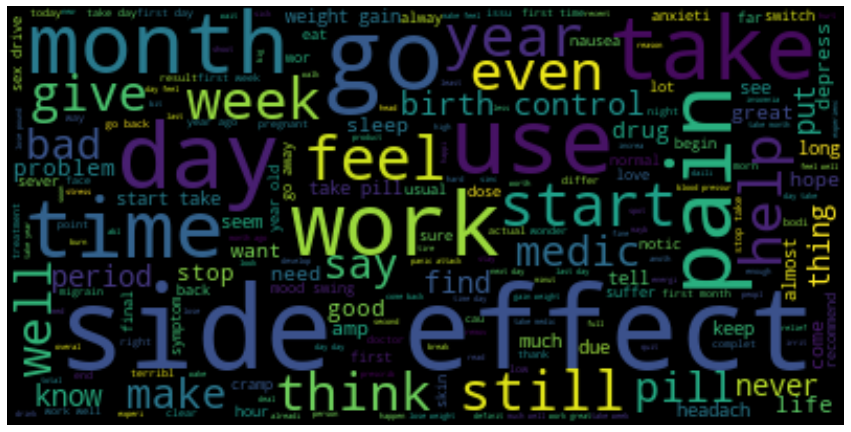

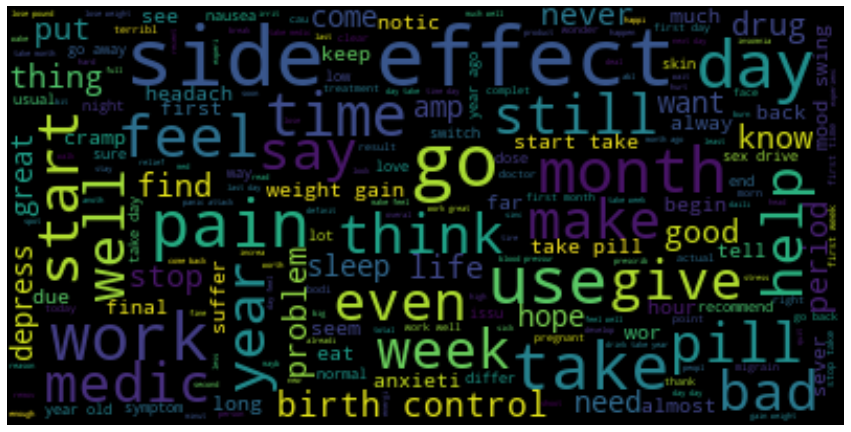

In [72]:
getWordCloud(s)

In [73]:
new_corpus = [str (item) for item in new_corpus]

In [74]:
data['new_review'] = new_corpus

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 50')

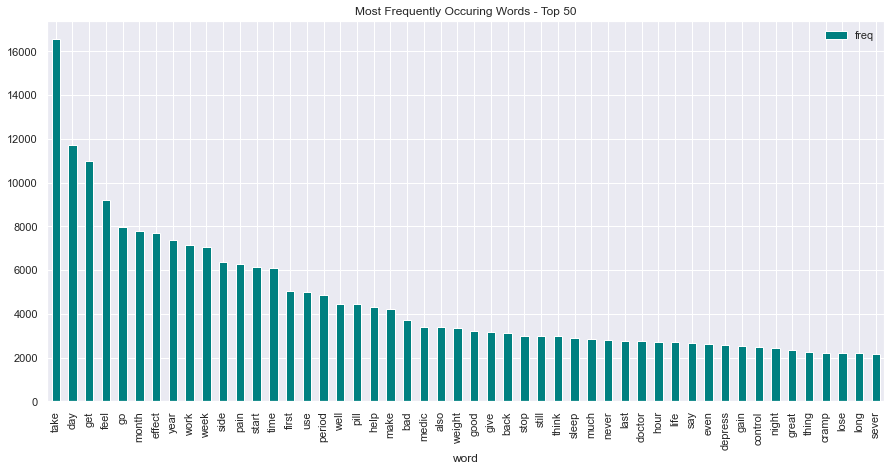

In [75]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
new_XX= cv.fit_transform(data['new_review'].values.astype('U'))

XX_words = new_XX.sum(axis=0)

XXwords_freq = [(word, XX_words[0, i]) for word, i in cv.vocabulary_.items()]
XXwords_freq = sorted(XXwords_freq, key = lambda x: x[1], reverse = True)

frequencyy = pd.DataFrame(XXwords_freq, columns=['word', 'freq'])

frequencyy.head(50).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'Teal')
plt.title("Most Frequently Occuring Words - Top 50")

In [41]:
data = data.drop(['Reviews'], axis=1)

In [42]:
data = data[['new_review', 'rating']] #rearranging the dataframe

# ANALYSIS
* After careful review, we will be using rating as label. 
* Note: Using sentiment as label might be biased. Oversampling is an option but 'rating' is preferred.

* Below, We will be mapping rating to binary 1 and 0. Less than 5 will be negative, greater than 5 will be postive



In [76]:
dataset = pd.read_csv('corpus.csv') #importing the last saved file
dataset.head(2)

,drugName,condition,rating,Reviews
0,Valsartan,Left Ventricular Dysfunction,9.0,side effect take combin bystol mg fish oil
1,Guanfacine,ADHD,8.0,son halfway fourth week intuniv becam concern ...


In [77]:
dataset['Liked'] = dataset['rating']
dataset

,drugName,condition,rating,Reviews,Liked
0,Valsartan,Left Ventricular Dysfunction,9.0,side effect take combin bystol mg fish oil,9.0
1,Guanfacine,ADHD,8.0,son halfway fourth week intuniv becam concern ...,8.0
2,Lybrel,Birth Control,5.0,use take anoth oral contracept pill cycl happi...,5.0
3,Ortho Evra,Birth Control,8.0,first time use form birth control glad went pa...,8.0
4,Buprenorphine / naloxone,Opiate Dependence,9.0,suboxon complet turn life around feel healthie...,9.0
...,...,...,...,...,...
19888,Ativan,Insomnia,9.0,given ativan occasion use tri use everi week e...,9.0
19889,Erythromycin,Upper Respiratory Tract Infection,10.0,antibiot best hand z pack even come close take...,10.0
19890,Plan B,Emergency Contraception,10.0,took pill june th realli scare amp nervou came...,10.0
19891,Dilaudid,Pain,10.0,develop sever pancreat hepat due gallston tri ...,10.0


In [78]:
dataset.loc[(dataset['Liked'] <= 5),'rating']= 0

In [79]:
dataset.loc[(dataset['Liked'] > 5),'rating']= 1
dataset

,drugName,condition,rating,Reviews,Liked
0,Valsartan,Left Ventricular Dysfunction,1.0,side effect take combin bystol mg fish oil,9.0
1,Guanfacine,ADHD,1.0,son halfway fourth week intuniv becam concern ...,8.0
2,Lybrel,Birth Control,0.0,use take anoth oral contracept pill cycl happi...,5.0
3,Ortho Evra,Birth Control,1.0,first time use form birth control glad went pa...,8.0
4,Buprenorphine / naloxone,Opiate Dependence,1.0,suboxon complet turn life around feel healthie...,9.0
...,...,...,...,...,...
19888,Ativan,Insomnia,1.0,given ativan occasion use tri use everi week e...,9.0
19889,Erythromycin,Upper Respiratory Tract Infection,1.0,antibiot best hand z pack even come close take...,10.0
19890,Plan B,Emergency Contraception,1.0,took pill june th realli scare amp nervou came...,10.0
19891,Dilaudid,Pain,1.0,develop sever pancreat hepat due gallston tri ...,10.0


In [80]:
dataset = dataset.drop(['drugName','condition', 'Liked'], axis=1)

In [81]:
print(len(dataset[dataset['rating']==1]))
print(len(dataset[dataset['rating']==0]))

13868
6025


In [82]:
dataset = dataset[['Reviews', 'rating']]

In [225]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=2000)
X = cv.fit_transform(df['Reviews']).toarray()
y = dataset.iloc[:, -1].values

### Splitting the dataset into the Training set and Test set

In [226]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# PART 1: SUPERVISED LEARNING ALGORITHMS

### Naive Bayes
Multinomia Naive Bayes is better used on a classification problem.

In [86]:
import time
start = time.time()
from sklearn.naive_bayes import MultinomialNB
clfNB = MultinomialNB()
clfNB.fit(X_train, y_train)
stop = time.time()
NBT = (stop-start) # Training  Time

In [87]:
# Training accuracy
from sklearn.metrics import accuracy_score
NB_training_accuracy = accuracy_score(y_train, clfNB.predict(X_train))
NB_training_accuracy * 100

79.39540183658423

### Predicting the Test set results

In [88]:
NBy_pred = clfNB.predict(X_test)
print(np.concatenate((NBy_pred.reshape(len(NBy_pred),1), y_test.reshape(len(y_test),1)),1))

[[0. 0.]
 [1. 1.]
 [1. 1.]
 ...
 [0. 0.]
 [1. 1.]
 [1. 1.]]


### Making the Confusion Matrix

In [89]:
# Test accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
NBcm = confusion_matrix(y_test, NBy_pred)
print(NBcm)
NBscore = accuracy_score(y_test, NBy_pred)
NBscore * 100

[[ 970  518]
 [ 604 2882]]


77.44270205066344

### Hyperparameter Tuning of Naive Bayes Using Grid Search
for Multinomial Naive Bayes, the smoothing is alpha: float, default=1.0
Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).

Result: No noticeable improvement after hyperparameter tuning

In [90]:
param_grid_nb = {
    'alpha': np.logspace(0,1, num=100)
}

In [91]:
nbModel_grid = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(X_train, y_train)
print(nbModel_grid.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
MultinomialNB(alpha=10.0)


In [92]:
NB_training_accuracy = accuracy_score(y_train, nbModel_grid.predict(X_train))
NB_training_accuracy

0.7952275621690462

### Classification Report Naive Bayes

In [93]:
NB_ypred = nbModel_grid.predict(X_test)
print(classification_report(y_test, NBy_pred, target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.62      0.65      0.63      1488
    Positive       0.85      0.83      0.84      3486

    accuracy                           0.77      4974
   macro avg       0.73      0.74      0.74      4974
weighted avg       0.78      0.77      0.78      4974



### Making a Single Review Prediction

Use our model to predict if the following review:

"This drug has changed my life"

is positive or negative.

In [94]:
single_review = "This drug has changed my life"
single_review = re.sub('[^a-zA-Z]', ' ', single_review)
single_review = single_review.lower()
single_review = single_review.split()
ps = PorterStemmer()
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')
single_review = [ps.stem(word) for word in single_review if not word in set(all_stopwords)]
single_review = ' '.join(single_review)
new_corp = [single_review]
new_X_test = cv.transform(new_corp).toarray()
new_y_pred = clfNB.predict(new_X_test)
print(new_y_pred)

[1.]


Use our model to predict if the following review:

"Do not buy this drug, its been terrible"

is positive or negative.

In [95]:
new_review = 'Do not buy this drug, its been terrible'
new_review = re.sub('[^a-zA-Z]', ' ', new_review)
new_review = new_review.lower()
new_review = new_review.split()
ps = PorterStemmer()
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')
new_review = [ps.stem(word) for word in new_review if not word in set(all_stopwords)]
new_review = ' '.join(new_review)
new_corpus = [new_review]
new_X_test = cv.transform(new_corpus).toarray()
new_y_pred = clfNB.predict(new_X_test)
print(new_y_pred)

[0.]


### Linear Discriminant Analysis

In [97]:
start = time.time()
LDAclf = LinearDiscriminantAnalysis(solver='svd') #svd is best used for large training data
LDAclf.fit(X_train, y_train)
stop = time.time()
LDAT = (stop-start) # Training  Time

In [98]:
LDA_training_accuracy = accuracy_score(y_train, LDAclf.predict(X_train))
LDA_training_accuracy

0.8455660567062135

In [99]:
LDAy_pred = LDAclf.predict(X_test)
LDAcm = confusion_matrix(y_test, LDAy_pred)
print(LDAcm)
LDAscore = accuracy_score(y_test, LDAy_pred)
LDAscore

[[ 796  692]
 [ 355 3131]]


0.7895054282267793

### Decision Tree

In [100]:
start = time.time()
from sklearn.tree import DecisionTreeClassifier
DTclf = DecisionTreeClassifier(max_depth=2, random_state=42)
DTclf.fit(X_train, y_train)
stop = time.time()
DT = (stop-start)

In [101]:
DT_training_accuracy = accuracy_score(y_train, DTclf.predict(X_train))
DT_training_accuracy

0.7102352704604866

In [102]:
DT_pred = DTclf.predict(X_test)
cm = confusion_matrix(y_test, DT_pred)
print(cm)
DT_score =accuracy_score(y_test, DT_pred)
DT_score

[[ 253 1235]
 [ 159 3327]]


0.7197426618415762

In [76]:
from sklearn import tree
from dtreeviz.trees import *

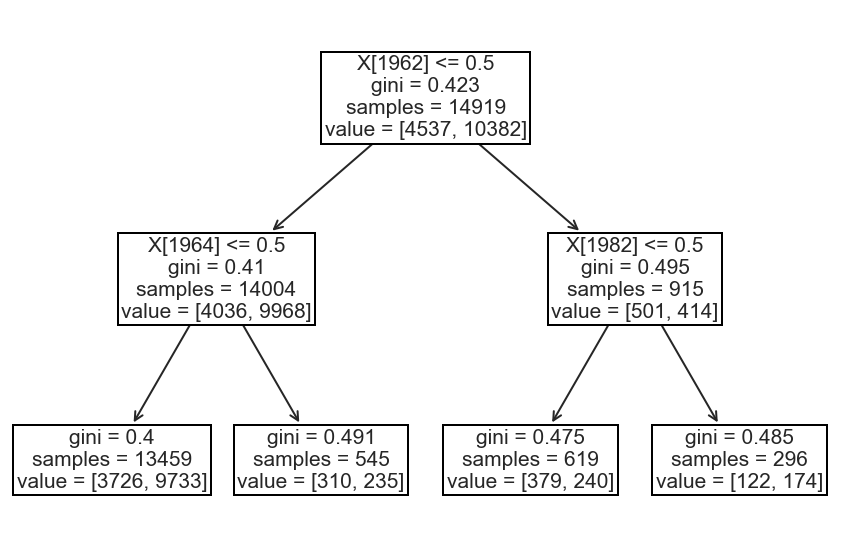

In [77]:
tree.plot_tree(DTclf);

### Bagging Decision Tree

In [103]:
from sklearn.ensemble import BaggingClassifier

Bagging_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=0).fit(X_train, y_train)
Bagging_clf

Bagging_clf.predict(X_test)

array([0., 1., 1., ..., 1., 1., 0.])

In [104]:
BGDT_pred = Bagging_clf.predict(X_test)
print(np.concatenate((BGDT_pred.reshape(len(BGDT_pred),1), y_test.reshape(len(y_test),1)),1))

[[0. 0.]
 [1. 1.]
 [1. 1.]
 ...
 [1. 0.]
 [1. 1.]
 [0. 1.]]


In [105]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, BGDT_pred)
print(cm)
BGDT_score = accuracy_score(y_test, BGDT_pred)
BGDT_score

[[ 797  691]
 [ 563 2923]]


0.7478890229191797

In [106]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


kfold = KFold(n_splits = 10, random_state = None)
bagging_result = cross_val_score(Bagging_clf, X_train, y_train, cv=kfold)
for i in range(len(bagging_result)):
    print("bagging_model: "+str(i)+" Accuracy is: "+str(bagging_result[i]))

bagging_model: 0 Accuracy is: 0.7278820375335121
bagging_model: 1 Accuracy is: 0.75
bagging_model: 2 Accuracy is: 0.7339142091152815
bagging_model: 3 Accuracy is: 0.7439678284182306
bagging_model: 4 Accuracy is: 0.7473190348525469
bagging_model: 5 Accuracy is: 0.7238605898123325
bagging_model: 6 Accuracy is: 0.7459785522788204
bagging_model: 7 Accuracy is: 0.7144772117962467
bagging_model: 8 Accuracy is: 0.7285522788203753
bagging_model: 9 Accuracy is: 0.7471495640509725


In [108]:
bgDTscore = print("Mean Accuracy: "+str(bagging_result.mean()))
bgDTscore #training accuracy after kfold 10splits.

Mean Accuracy: 0.7363101306678318


### Random Forest Classifier

In [109]:
start = time.time()
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = 0)
classifier.fit(X_train, y_train)
stop = time.time()
RF = (stop-start)

In [110]:
RF_training_accuracy = accuracy_score(y_train, classifier.predict(X_train))
RF_training_accuracy

0.9997318855151149

In [111]:
RF_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, RF_pred)
print(cm)
RF_score = accuracy_score(y_test, RF_pred)
RF_score

[[ 589  899]
 [ 136 3350]]


0.7919179734620024

# Part 2: NEURAL NETWORK

#  LSTM
 * LSTM for text review does not require text cleaning

In [112]:
LSTM_df = pd.concat([dataset_1,dataset_2])[['drugName','condition','review', 'rating']]
LSTM_df

,drugName,condition,review,rating
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0
...,...,...,...,...
9995,Ativan,Insomnia,"""I was given Ativan for occasional use. I try ...",9.0
9996,Erythromycin,Upper Respiratory Tract Infection,"""This antibiotic is the best, hands down. The...",10.0
9997,Plan B,Emergency Contraception,"""I took this pill on June 16th 2015. I was rea...",10.0
9998,Dilaudid,Pain,"""I developed severe pancreatitis and hepatitis...",10.0


In [113]:
LSTM_df['Liked'] = LSTM_df['rating']

In [114]:
LSTM_df

,drugName,condition,review,rating,Liked
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,9.0
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,8.0
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,5.0
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,8.0
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,9.0
...,...,...,...,...,...
9995,Ativan,Insomnia,"""I was given Ativan for occasional use. I try ...",9.0,9.0
9996,Erythromycin,Upper Respiratory Tract Infection,"""This antibiotic is the best, hands down. The...",10.0,10.0
9997,Plan B,Emergency Contraception,"""I took this pill on June 16th 2015. I was rea...",10.0,10.0
9998,Dilaudid,Pain,"""I developed severe pancreatitis and hepatitis...",10.0,10.0


In [115]:
LSTM_df.loc[(LSTM_df['Liked'] <= 5),'rating']= "Negative"
LSTM_df.loc[(LSTM_df['Liked'] > 5),'rating']= "positive"

In [116]:
new_LSTM_df = LSTM_df[['review', 'rating']]

In [117]:
from keras.preprocessing.text import Tokenizer

new_LSTM_df['review'] = new_LSTM_df['review'].apply(lambda x: x.lower())
new_LSTM_df['review'] = new_LSTM_df['review'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(new_LSTM_df[ new_LSTM_df['rating'] == 'positive'].size)
print(new_LSTM_df[ new_LSTM_df['rating'] == 'Negative'].size)

for idx,row in new_LSTM_df.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(new_LSTM_df['review'].values)
X_LSTM = tokenizer.texts_to_sequences(new_LSTM_df['review'].values)
X_LSTM = pad_sequences(X_LSTM)

27876
12124


In [118]:
embed_dim = 128
lstm_out = 196
max_features = 2000

model_LSTM = Sequential()
model_LSTM.add(Embedding(max_features, embed_dim,input_length = X_LSTM.shape[1]))
model_LSTM.add(SpatialDropout1D(0.2))
model_LSTM.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model_LSTM.add(Dense(2,activation='softmax'))


model_LSTM.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model_LSTM.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 538, 128)          256000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 538, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 2)                 394       
                                                                 
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [119]:
Y_LSTM = pd.get_dummies(new_LSTM_df['rating']).values
X_LSTM_train, X_LSTM_test, Y_LSTM_train, Y_LSTM_test = train_test_split(X_LSTM,Y_LSTM, test_size = 0.20, random_state = 42)

In [120]:
print(X_LSTM_train.shape,Y_LSTM_train.shape)
print(X_LSTM_test.shape,Y_LSTM_test.shape)

(16000, 538) (16000, 2)
(4000, 538) (4000, 2)


In [121]:
batch_size = 32
model_LSTM.fit(X_LSTM_train, Y_LSTM_train, epochs = 10, batch_size=batch_size, verbose = 2)

Epoch 1/10
500/500 - 1624s - loss: 0.5051 - accuracy: 0.7588 - 1624s/epoch - 3s/step
Epoch 2/10
500/500 - 1579s - loss: 0.4051 - accuracy: 0.8199 - 1579s/epoch - 3s/step
Epoch 3/10
500/500 - 1572s - loss: 0.3624 - accuracy: 0.8441 - 1572s/epoch - 3s/step
Epoch 4/10
500/500 - 1602s - loss: 0.3287 - accuracy: 0.8631 - 1602s/epoch - 3s/step
Epoch 5/10
500/500 - 1589s - loss: 0.2986 - accuracy: 0.8766 - 1589s/epoch - 3s/step
Epoch 6/10
500/500 - 1579s - loss: 0.2775 - accuracy: 0.8850 - 1579s/epoch - 3s/step
Epoch 7/10
500/500 - 1490s - loss: 0.2535 - accuracy: 0.8975 - 1490s/epoch - 3s/step
Epoch 8/10
500/500 - 1681s - loss: 0.2398 - accuracy: 0.9038 - 1681s/epoch - 3s/step
Epoch 9/10
500/500 - 1841s - loss: 0.2184 - accuracy: 0.9112 - 1841s/epoch - 4s/step
Epoch 10/10
500/500 - 1795s - loss: 0.2010 - accuracy: 0.9194 - 1795s/epoch - 4s/step


In [123]:
lstm_val_loss,lstm_val_acc = model_LSTM.evaluate(X_LSTM_test, Y_LSTM_test, verbose = 2, batch_size = 32)

125/125 - 62s - loss: 0.5612 - accuracy: 0.8002 - 62s/epoch - 493ms/step


In [192]:
loss, acc = model_LSTM.evaluate(X_LSTM_train, Y_LSTM_train, verbose=0)

In [165]:
print("Model Training Score")
print('Train Accuracy:', acc) 
print('Train loss:', loss)

Model Training Score
Train Accuracy: 0.9530624747276306
Train loss: 0.1407988965511322


# LSTM 2

In [264]:
embed_dim = 128
lstm_out = 200
max_features = 2000

LSTM_2 = Sequential()
LSTM_2.add(Embedding(max_features, embed_dim,input_length = X_LSTM.shape[1]))
LSTM_2.add(SpatialDropout1D(0.2))
LSTM_2.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
LSTM_2.add(Dense(2,activation='sigmoid'))


LSTM_2.compile(loss = 'categorical_crossentropy', optimizer='RMSProp',metrics = ['accuracy'])
print(LSTM_2.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 538, 128)          256000    
                                                                 
 spatial_dropout1d_7 (Spatia  (None, 538, 128)         0         
 lDropout1D)                                                     
                                                                 
 lstm_7 (LSTM)               (None, 200)               263200    
                                                                 
 dense_19 (Dense)            (None, 2)                 402       
                                                                 
Total params: 519,602
Trainable params: 519,602
Non-trainable params: 0
_________________________________________________________________
None


In [265]:
batch_size = 32
history = LSTM_2.fit(X_LSTM_train, Y_LSTM_train, epochs = 5, batch_size=batch_size, verbose = 2)

Epoch 1/5
500/500 - 1607s - loss: 0.5492 - accuracy: 0.7368 - 1607s/epoch - 3s/step
Epoch 2/5
500/500 - 1435s - loss: 0.4276 - accuracy: 0.8121 - 1435s/epoch - 3s/step
Epoch 3/5
500/500 - 1536s - loss: 0.3895 - accuracy: 0.8331 - 1536s/epoch - 3s/step
Epoch 4/5
500/500 - 1553s - loss: 0.3675 - accuracy: 0.8447 - 1553s/epoch - 3s/step
Epoch 5/5
500/500 - 1412s - loss: 0.3538 - accuracy: 0.8492 - 1412s/epoch - 3s/step


In [266]:
lstm_2_val_loss,lstm_2_val_acc = LSTM_2.evaluate(X_LSTM_test, Y_LSTM_test, verbose = 2, batch_size = 32)

125/125 - 55s - loss: 0.4035 - accuracy: 0.8217 - 55s/epoch - 441ms/step


In [267]:
lstm_2_loss, lstm_2_acc = LSTM_2.evaluate(X_LSTM_train, Y_LSTM_train, verbose=0)

In [268]:
lstm_2_loss, lstm_2_acc

(0.31944069266319275, 0.8769999742507935)

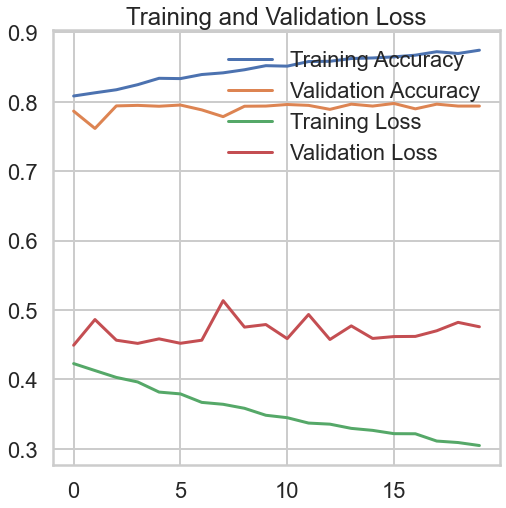

In [295]:
lstm_2_acc = history.history['accuracy'] 
lstm_2_val_acc = history.history['val_accuracy'] 
lstm_2_loss = history.history['loss'] 
lstm_2_val_loss = history.history['val_loss'] 
epochs_range = range(epochs) 
plt.figure(figsize=(8, 8)) 
plt.plot(epochs_range, lstm_2_acc, label='Training Accuracy') 
plt.plot(epochs_range, lstm_2_val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right') 
plt.title('Training and Validation Accuracy') 
plt.plot(epochs_range, lstm_2_loss, label='Training Loss') 
plt.plot(epochs_range, lstm_2_val_loss, label='Validation Loss') 
plt.legend(loc='upper right') 
plt.title('Training and Validation Loss') 
plt.show() 

# Bidirectional LSTM

In [302]:
max_words = 10000
max_len=50

def tokenize_pad_sequences(text):
    
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', new_LSTM_df['review'][0])
Bi_LSTM, tokenizer = tokenize_pad_sequences(new_LSTM_df['review'])
print('After Tokenization & Padding \n', Bi_LSTM[0])

Before Tokenization & Padding 
 0    it has no side effect i take it in combination...
0    i039ve tried a few antidepressants over the ye...
Name: review, dtype: object
After Tokenization & Padding 
 [   7   37   26   34  199    1   44    7   14  887   11 3755  147  146
    2 3658 1325    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [303]:
#splitting tokens into training and test set
Bi_yLSTM = pd.get_dummies(new_LSTM_df['rating']).values
Bi_LSTM_Xtrain, Bi_LSTM_Xtest, Bi_LSTM_ytrain, Bi_LSTM_ytest = train_test_split(Bi_LSTM,Bi_yLSTM, test_size = 0.20, 
                                                                            random_state = 42)

In [304]:
vocab_size = 10000
embedding_size = 32
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
max_len=50

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

In [305]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 32
history = model.fit(Bi_LSTM_Xtrain, Bi_LSTM_ytrain,
                      validation_data=(Bi_LSTM_Xtest, Bi_LSTM_ytest),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 50, 32)            320000    
                                                                 
 conv1d_5 (Conv1D)           (None, 50, 32)            3104      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 25, 32)           0         
 1D)                                                             
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 2)               

In [306]:
# Evaluate model on the test set
bi_loss, Bi_accuracy, precision, recall = model.evaluate(Bi_LSTM_Xtrain, Bi_LSTM_ytrain, verbose=0) 

In [307]:
bi_loss, Bi_accuracy

(0.6094387173652649, 0.6968125104904175)

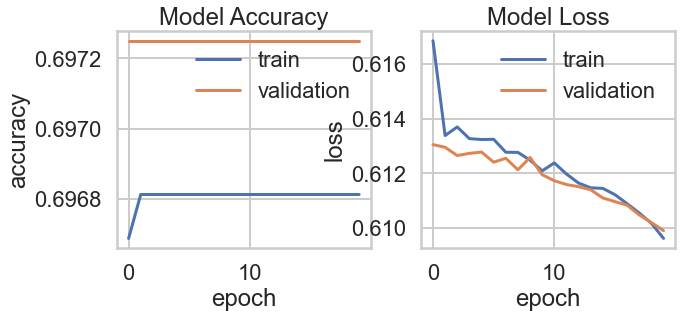

In [308]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

# ARTIFICIAL NEURAL NETWORK

In [227]:
model_1 = Sequential() 
model_1.add(Dense(units=2000, activation='relu', input_shape=(2000,)))  #Adding the input layer
model_1.add(Dropout(0.2))
model_1.add(Dense(1, activation='sigmoid')) # Adding the output layer

model_1.summary()

model_1.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 2000)              4002000   
                                                                 
 dropout_8 (Dropout)         (None, 2000)              0         
                                                                 
 dense_15 (Dense)            (None, 1)                 2001      
                                                                 
Total params: 4,004,001
Trainable params: 4,004,001
Non-trainable params: 0
_________________________________________________________________


In [228]:
batch_size = 32
epochs = 10

history = model_1.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_data=(X_test, y_test))
score_1 = model_1.evaluate(X_test, y_test, verbose=0)

Epoch 1/10
467/467 [==============================] - 16s 34ms/step - loss: 0.4617 - accuracy: 0.7907 - val_loss: 0.4142 - val_accuracy: 0.8102
Epoch 2/10
467/467 [==============================] - 16s 33ms/step - loss: 0.2841 - accuracy: 0.8834 - val_loss: 0.4302 - val_accuracy: 0.8158
Epoch 3/10
467/467 [==============================] - 15s 33ms/step - loss: 0.1212 - accuracy: 0.9590 - val_loss: 0.5207 - val_accuracy: 0.8152
Epoch 4/10
467/467 [==============================] - 15s 33ms/step - loss: 0.0347 - accuracy: 0.9928 - val_loss: 0.6102 - val_accuracy: 0.8130
Epoch 5/10
467/467 [==============================] - 18s 38ms/step - loss: 0.0124 - accuracy: 0.9979 - val_loss: 0.7356 - val_accuracy: 0.8207
Epoch 6/10
467/467 [==============================] - 18s 38ms/step - loss: 0.0061 - accuracy: 0.9994 - val_loss: 0.7892 - val_accuracy: 0.8158
Epoch 7/10
467/467 [==============================] - 20s 43ms/step - loss: 0.0038 - accuracy: 0.9995 - val_loss: 0.8646 - val_accuracy:

In [229]:
loss_1, acc_1,  = model_1.evaluate(X_train, y_train, verbose=0)

In [230]:
print(loss_1)
print(acc_1)

0.0012778118252754211
0.9997988939285278


In [231]:
print("score")
print('Test loss:', score_1[0]) 
print('Test accuracy:', score_1[1])

score
Test loss: 0.9755786657333374
Test accuracy: 0.8138319253921509


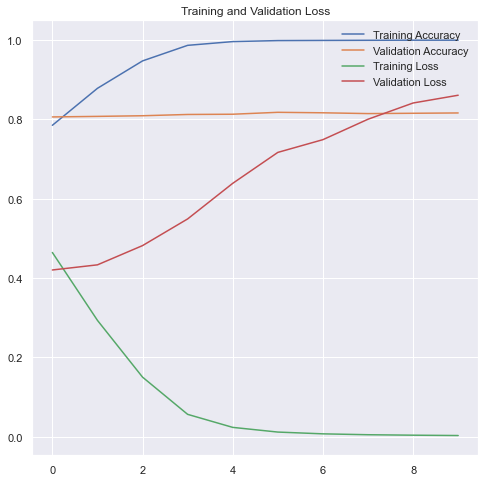

In [140]:
acc_1 = history.history['accuracy'] 
score_1[1] = history.history['val_accuracy'] 
loss_1 = history.history['loss'] 
score_1[0] = history.history['val_loss'] 
epochs_range = range(epochs) 
plt.figure(figsize=(8, 8)) 
plt.plot(epochs_range, acc_1, label='Training Accuracy') 
plt.plot(epochs_range, score_1[1], label='Validation Accuracy') 
plt.legend(loc='lower right') 
plt.title('Training and Validation Accuracy') 
plt.plot(epochs_range, loss_1, label='Training Loss') 
plt.plot(epochs_range, score_1[0], label='Validation Loss') 
plt.legend(loc='upper right') 
plt.title('Training and Validation Loss') 
plt.show() 

#  PRE-TRAINED BERT

For reviews without ratings, we will use pretrained transformer to rate the comments.<br>
First, for experimentation, we will crawl an online website [zavamed](https://www.zavamed.com/uk/microgynon-30.html) for reviews on a birth control pill to make an independent prediction of the reviews, we will then use transformers on our dataset.

Requirements:
* Downloaded and installed the pretrained nlp model from [Huggingface](
https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment)
* The pretrained model classifies text reviews and creates its ratings.
* Installed Pytorch and all updated all its dependencies(pytorch.org).
* Installed imported BeautifulSoup4 for web scrapping.
* Regex to tap the area needed from the webpage above.

In [146]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoModel, AutoTokenizer
import torch
import requests
from bs4 import BeautifulSoup
import re

In [147]:
#loading the pretrained model
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment') 
#source:https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment
transformers_model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [148]:
tokens = tokenizer.encode("I hate this. Absolutely the worst", return_tensors='pt')

In [149]:
result = transformers_model(tokens)

In [150]:
result

SequenceClassifierOutput(loss=None, logits=tensor([[ 5.1286,  1.6025, -1.0756, -3.0451, -1.8454]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [151]:
torch.argmax(result.logits)

tensor(0)

In [152]:
int(torch.argmax(result.logits))+1

1

### MAKING AN INDEPENDENT PREDICTION
* We will be making an independent prediction by scrapping a website that sells Birth Control Pills. 

In [153]:
r = requests.get('https://www.zavamed.com/uk/microgynon-30.html')
soup = BeautifulSoup(r.text, 'html.parser')
regex = re.compile('.*TrustpilotReview-comment.*')
results = soup.find_all('div', {'class':regex})
reviews = [result.text for result in results] # this picks out only the text from the results list that contains html tags

In [154]:
results #prints all parts of the webpage that is wrapped in TrustpilotReview-comment in a div 

[<div class="TrustpilotReview-comment" itemprop="reviewBody">
 goood , no pain, no bad symptoms after using, i love it </div>,
 <div class="TrustpilotReview-comment" itemprop="reviewBody">
 Fast delivery and always good tracking . The product is really good </div>,
 <div class="TrustpilotReview-comment" itemprop="reviewBody">
 Very good! </div>,
 <div class="TrustpilotReview-comment" itemprop="reviewBody">
 Quick and easy </div>,
 <div class="TrustpilotReview-comment" itemprop="reviewBody">
 Great Customer Service, Fast Delivery. </div>,
 <div class="TrustpilotReview-comment" itemprop="reviewBody">
 Excellent service. Very quick delivery. Highly recommend. </div>,
 <div class="TrustpilotReview-comment" itemprop="reviewBody">
 .......
 .. </div>,
 <div class="TrustpilotReview-comment" itemprop="reviewBody">
 I’m satisfied </div>,
 <div class="TrustpilotReview-comment" itemprop="reviewBody">
 This is my second order now and it is working very effectively. I got the 21 days pill then the 

In [155]:
reviews[0]

'\ngoood , no pain, no bad symptoms after using, i love it '

In [156]:
web_review = pd.DataFrame(np.array(reviews), columns=['review'])

In [157]:
web_review['review'].iloc[0]

'\ngoood , no pain, no bad symptoms after using, i love it '

In [158]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = transformers_model(tokens)
    return int(torch.argmax(result.logits))+1

In [159]:
sentiment_score(web_review['review'].iloc[1]) #The result show that the second review is a very positive review

5

In [160]:
web_review['sentiment'] = web_review['review'].apply(lambda x: sentiment_score(x[:512]))

In [161]:
web_review['review'].head(2)

0    \ngoood , no pain, no bad symptoms after using...
1    \nFast delivery and always good tracking . The...
Name: review, dtype: object

In [162]:
web_review

,review,sentiment
0,"\ngoood , no pain, no bad symptoms after using...",5
1,\nFast delivery and always good tracking . The...,5
2,\nVery good!,5
3,\nQuick and easy,5
4,"\nGreat Customer Service, Fast Delivery.",5
5,\nExcellent service. Very quick delivery. High...,5
6,\n.......\n..,1
7,\nI’m satisfied,4
8,\nThis is my second order now and it is workin...,5
9,\nVery happy for the way I’ve been acessed by ...,5


# PRE-TRAINED BERT ON DRUG REVIEW DATASET

In [163]:
transformer_drug_review = pd.read_csv('textsentiment.csv')
transformer_drug_review.head(2)

,drugName,condition,review,rating
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0


In [164]:
transformer_drug_review['sentiment'] = transformer_drug_review['review'].apply(lambda x: sentiment_score(x[:512]))

In [166]:
transformer_drug_review

,drugName,condition,review,rating,sentiment
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,2
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,2
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,2
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,4
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,5
...,...,...,...,...,...
19888,Ativan,Insomnia,"""I was given Ativan for occasional use. I try ...",9.0,4
19889,Erythromycin,Upper Respiratory Tract Infection,"""This antibiotic is the best, hands down. The...",10.0,5
19890,Plan B,Emergency Contraception,"""I took this pill on June 16th 2015. I was rea...",10.0,4
19891,Dilaudid,Pain,"""I developed severe pancreatitis and hepatitis...",10.0,1


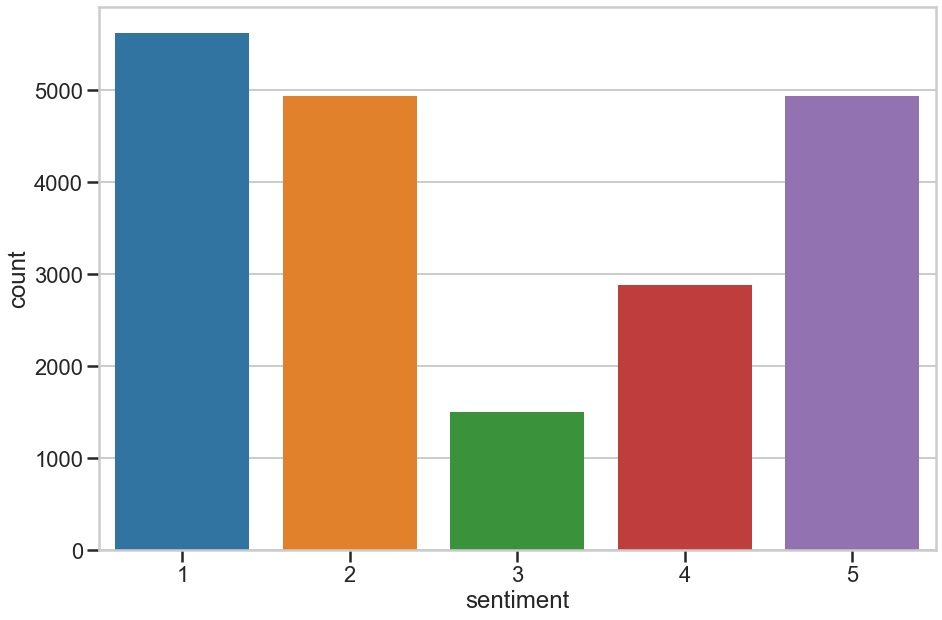

In [131]:
ax = sns.countplot(data=transformer_drug_review, x='sentiment')

# BERT with KTRAIN

In [167]:
# The full data
full_data = pd.concat([dataset_1,dataset_2])[['drugName','condition','review', 'rating']]

In [172]:
full_data.head(1)

,drugName,condition,review,rating
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0


In [168]:
import os.path
import numpy as np
import tensorflow as tf
import ktrain
from ktrain import text

In [176]:
# converted  ratings to 1 and 0 because ktrain can only accommodate target less than 10.
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 5:
        return 0
    elif rating > 5:
        return 1

    
    
full_data['sentiment'] = full_data.rating.apply(to_sentiment)

In [177]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(full_data, 
                                                                   'review', # name of column containing review text
                                                                   label_columns=['sentiment'],
                                                                   maxlen=75, 
                                                                   max_features=100000,
                                                                   preprocess_mode='bert',
                                                                   val_pct=0.1)

['not_sentiment', 'sentiment']
      not_sentiment  sentiment
3001            0.0        1.0
9766            1.0        0.0
5184            0.0        1.0
3407            0.0        1.0
91              0.0        1.0
['not_sentiment', 'sentiment']
      not_sentiment  sentiment
8298            0.0        1.0
7942            0.0        1.0
6638            1.0        0.0
1258            0.0        1.0
7917            0.0        1.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [178]:
model = text.text_classifier('bert', (x_train, y_train) , preproc=preproc)
learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=32)

Is Multi-Label? False
maxlen is 75
done.


## Note: learner.lr_find() function was interrupted because of long hours of execution.

learner.lr_find()             # briefly simulate training to find good learning rate<br>
learner.lr_plot()             # visually identify best learning rate<br>

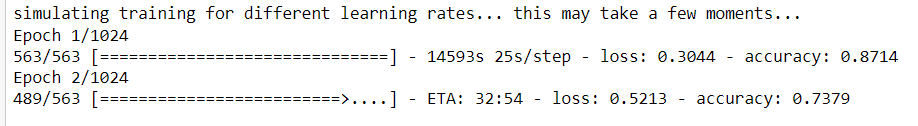

In [179]:
learner.fit_onecycle(2e-5, 1)



begin training using onecycle policy with max lr of 2e-05...
563/563 [==============================] - 14407s 25s/step - loss: 0.4543 - accuracy: 0.7840 - val_loss: 0.3221 - val_accuracy: 0.8625


In [190]:
learner.validate() # classification report in ktrain

              precision    recall  f1-score   support

           0       0.80      0.73      0.76       605
           1       0.89      0.92      0.90      1395

    accuracy                           0.86      2000
   macro avg       0.84      0.82      0.83      2000
weighted avg       0.86      0.86      0.86      2000



array([[ 439,  166],
       [ 109, 1286]], dtype=int64)

# MAKING A NEW PREDICTION

In [180]:
p = ktrain.get_predictor(learner.model, preproc)

In [195]:
p.predict("The side effect of this drug gives me acne. This should not have been in the market")

'not_sentiment'

In [196]:
p.predict("What an exceptional product")

'sentiment'

# Saving Model

In [197]:
# save model for later use
p.save('/project/drugreview_BERTpredictor')

# Model Table Results

In [252]:
my_table = {'Model Name':  ['LSTM', 'ANN','Naive Bayes', 'LDA', 'CART', 'Random Forest'],
        'Accuracy (train)': [acc, acc_1, NB_training_accuracy, LDA_training_accuracy, 
                             DT_training_accuracy, RF_training_accuracy],
        'Accuracy (validation)':[lstm_val_acc, score_1[1], NBscore, LDAscore, DT_score, 
                                 RF_score]
        }


Model_table = pd.DataFrame.from_dict(my_table)

Model_table

,Model Name,Accuracy (train),Accuracy (validation)
0,LSTM,0.953062,0.800250
1,ANN,0.999799,0.813832
2,Naive Bayes,0.795228,0.774427
3,LDA,0.845566,0.789505
4,CART,0.710235,0.719743
5,Random Forest,0.999732,0.791918


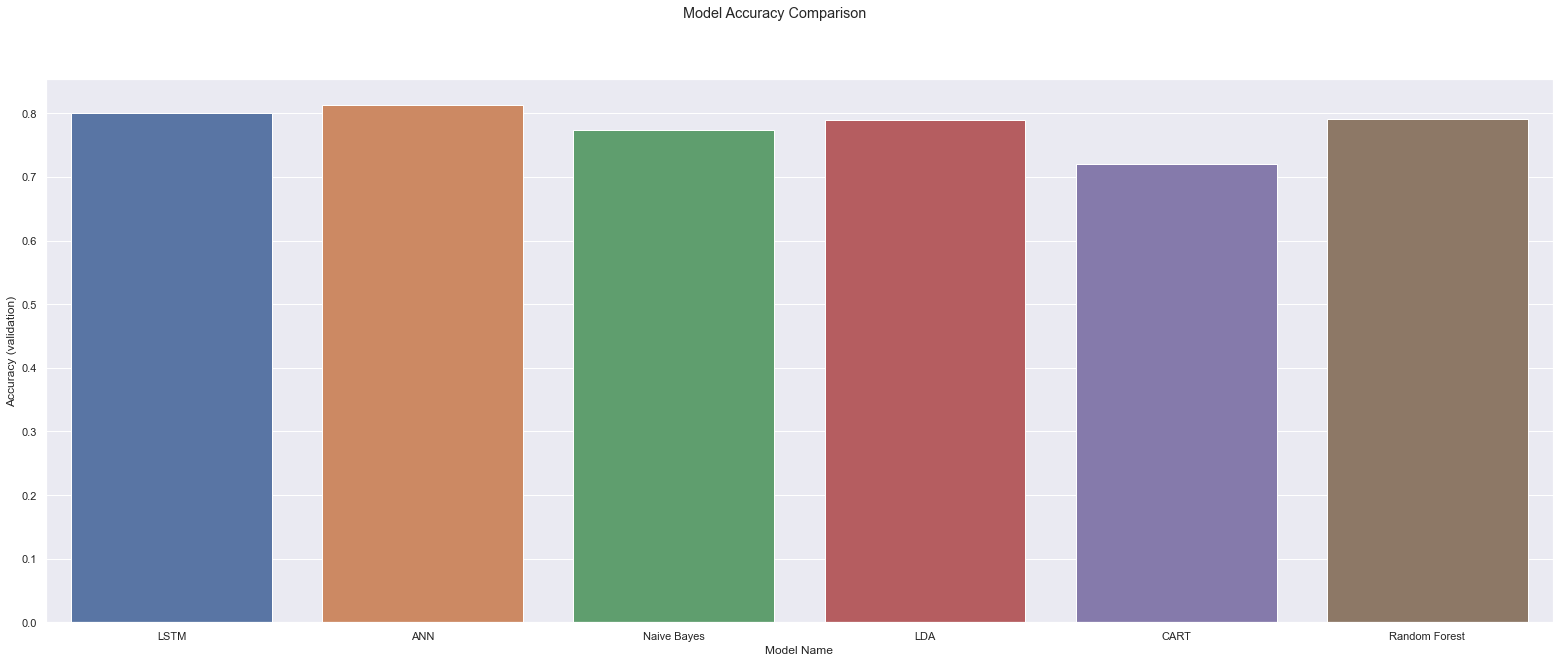

In [253]:
fig = plt.figure(figsize=(27,10))
fig.suptitle('Model Accuracy Comparison')
ax = sns.barplot(x="Model Name", y="Accuracy (validation)",data=Model_table)

# References

Drug Review Dataset - [UCI Repository](https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29) <br>
Save and load a model using a distribution strategy- [Tensorflow documentation](https://www.tensorflow.org/tutorials/distribute/save_and_load) <br>
Build Ktrain BERT -[Ktrain documentation](https://github.com/amaiya/ktrain <br>
ktrain: A Lightweight Wrapper for Keras to Help Train Neural Networks - [Tuning the Learning Rate](https://towardsdatascience.com/ktrain-a-lightweight-wrapper-for-keras-to-help-train-neural-networks-82851ba889c)